# Exploratory analysis of the data

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# Load the datasets back from CSV files

period_names = ['1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2020']
loaded_datasets = {}

for period_name in period_names:
    loaded_datasets[period_name] = pd.read_csv(f"datasets/climate_features_{period_name}.csv")
    print(f"Loaded climate_features_{period_name}.csv with shape {loaded_datasets[period_name].shape}")
    # print the size in ko of the loaded dataset
    print(f"Size in ko: {loaded_datasets[period_name].memory_usage(deep=True).sum() / 1024}")

Loaded climate_features_1970-1979.csv with shape (58, 50)
Size in ko: 22.78515625
Loaded climate_features_1980-1989.csv with shape (58, 50)
Size in ko: 22.78515625
Loaded climate_features_1990-1999.csv with shape (58, 50)
Size in ko: 22.78515625
Loaded climate_features_2000-2009.csv with shape (58, 50)
Size in ko: 22.78515625
Loaded climate_features_2010-2020.csv with shape (58, 50)
Size in ko: 22.78515625


In [14]:
eu_capitals = pd.read_csv("datasets/eu_capitals.csv")

In [15]:
# Useful definitions
bern = eu_capitals[eu_capitals['name'] == 'Bern']
bern_lat = bern.latitude.values[0]
bern_lon = bern.longitude.values[0]

month_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

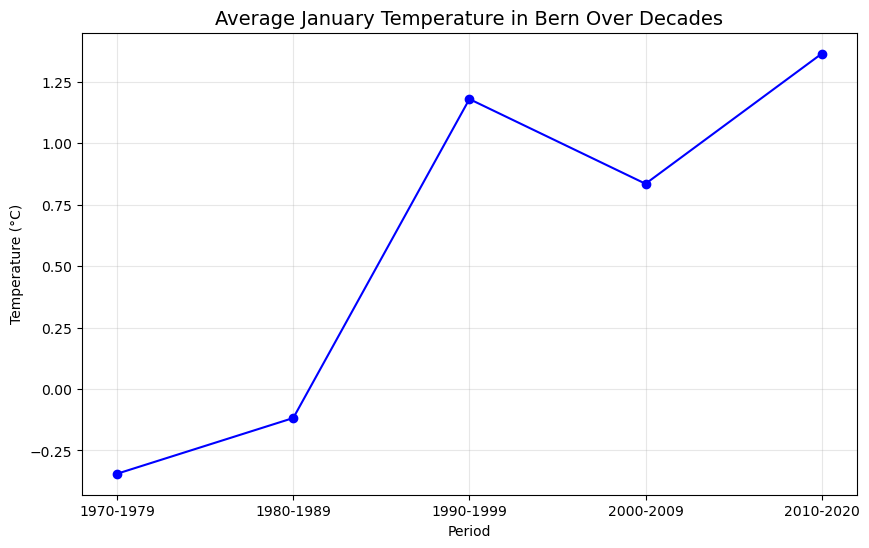

In [16]:
# Display the evolution of the temperature (t2m) in january for Bern over the decades

t2m_january = []
period_labels = []

for period_name in period_names:
    df = loaded_datasets[period_name]
    # Find the row corresponding to Bern
    bern_row = df[(df['latitude'] == bern_lat) & (df['longitude'] == bern_lon)]
    if not bern_row.empty:
        t2m_jan_value = bern_row['t2m_jan'].values[0]
        # Convert from Kelvin to Celsius
        t2m_january.append(t2m_jan_value - 273.15)  
        period_labels.append(period_name)
    else:
        t2m_january.append(np.nan)
        period_labels.append(period_name)

plt.figure(figsize=(10, 6))
plt.plot(period_labels, t2m_january, marker='o', linestyle='-', color='b', label='January')
plt.title('Average January Temperature in Bern Over Decades', fontsize=14)
plt.xlabel('Period')
plt.ylabel('Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.show()

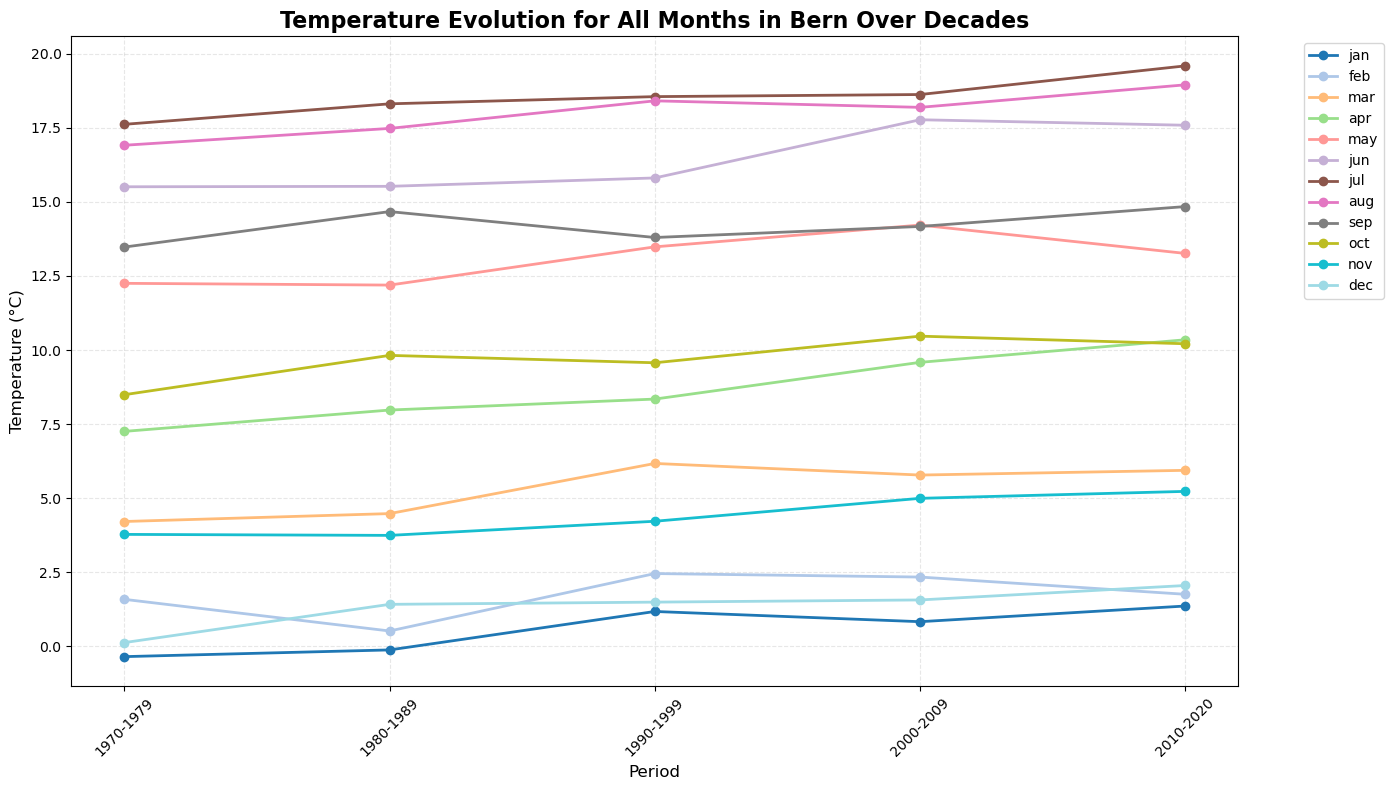

In [17]:
# Display the evolution of the temperature for all months in Bern over the decades

# Dictionary to store temperature data for each month
t2m_by_month = {month: [] for month in month_names}

# Extract data for each period
for period_name in period_names:
    df = loaded_datasets[period_name]
    bern_row = df[(df['latitude'] == bern_lat) & (df['longitude'] == bern_lon)]
    
    if not bern_row.empty:
        for month in month_names:
            t2m_value = bern_row[f't2m_{month}'].values[0]
            t2m_by_month[month].append(t2m_value - 273.15)  # Convert to Celsius
    else:
        for month in month_names:
            t2m_by_month[month].append(np.nan)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each month with a different color
colors = plt.cm.tab20(np.linspace(0, 1, 12))

for i, (month, label) in enumerate(zip(month_names, month_names)):
    ax.plot(period_names, t2m_by_month[month], 
            marker='o', linestyle='-', linewidth=2, 
            color=colors[i], label=label, markersize=6)

ax.set_title('Temperature Evolution for All Months in Bern Over Decades', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


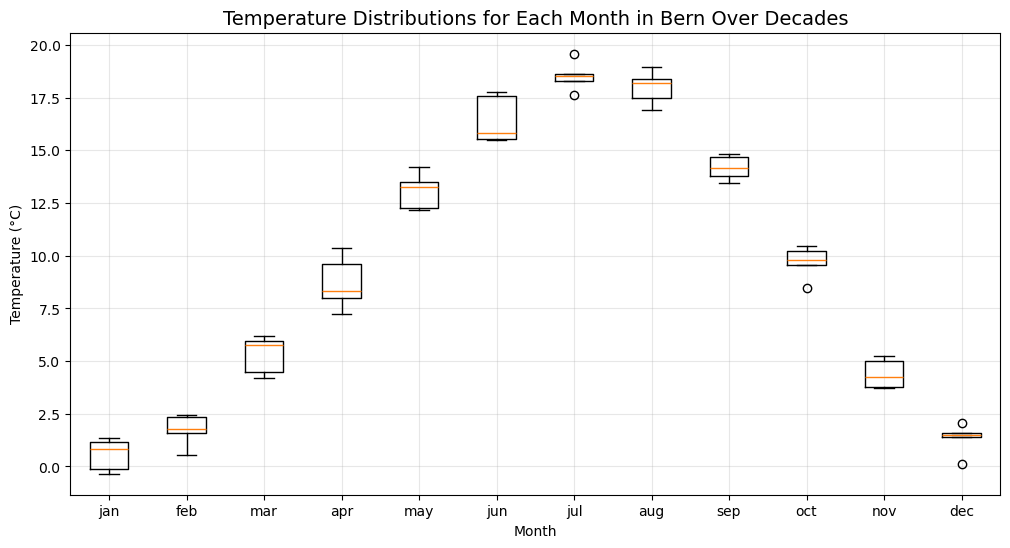

In [18]:
# Boxplots of temperature distributions for all  months in Bern over the decades

t2m_data = {month: [] for month in range(1, 13)}  # Dictionary to hold data for each month

for period_name in period_names:
    df = loaded_datasets[period_name]
    # Find the row corresponding to Bern
    bern_row = df[(df['latitude'] == bern_lat) & (df['longitude'] == bern_lon)]
    if not bern_row.empty:
        for month in range(1, 13):
            month_name = month_names[month - 1]
            t2m_value = bern_row[f't2m_{month_name}'].values[0]
            t2m_data[month].append(t2m_value - 273.15)  # Convert from Kelvin to Celsius
    else:
        for month in range(1, 13):
            t2m_data[month].append(np.nan)
# Prepare data for boxplot
boxplot_data = [t2m_data[month] for month in range(1, 13)]
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, tick_labels=month_names)
plt.title('Temperature Distributions for Each Month in Bern Over Decades', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.show()

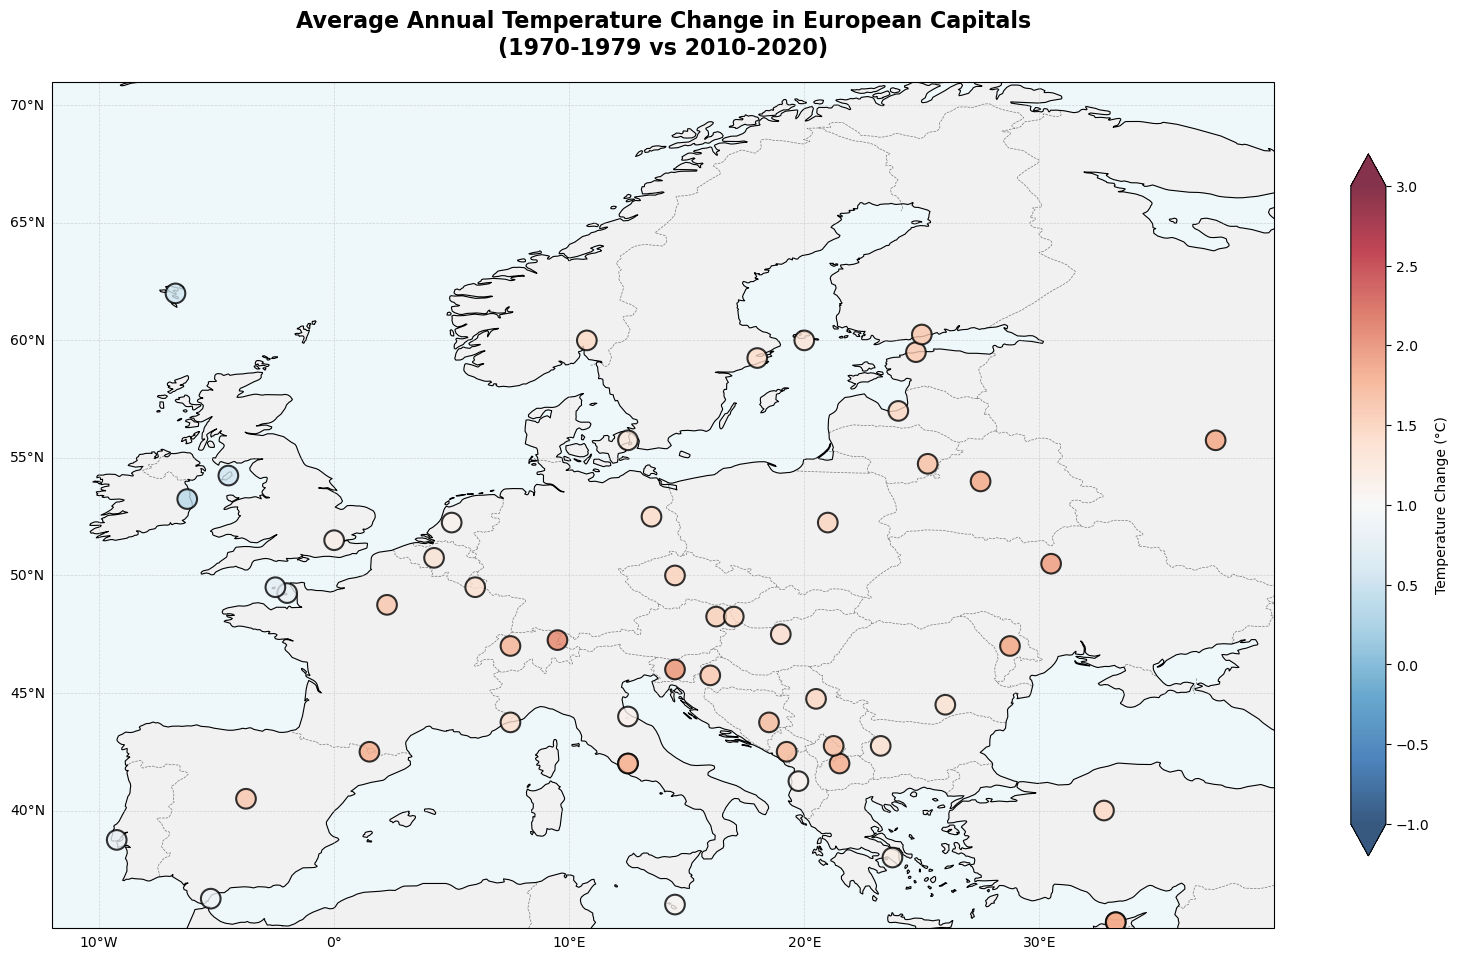

Average warming across all capitals: 1.42°C
Max warming: 2.32°C
Min warming: 0.44°C


In [19]:
# Map with temperature change across all European capitals

# Calculate temperature change between first and last period
df_1970 = loaded_datasets['1970-1979']
df_2010 = loaded_datasets['2010-2020']

temp_change = []
lats_plot = []
lons_plot = []

for _, row_70 in df_1970.iterrows():
    lat = row_70['latitude']
    lon = row_70['longitude']
    row_10 = df_2010[(df_2010['latitude'] == lat) & (df_2010['longitude'] == lon)]
    
    if not row_10.empty:
        # Calculate mean annual temperature for both periods
        temp_70 = np.mean([row_70[f't2m_{m}'] for m in month_names])
        temp_10 = np.mean([row_10.iloc[0][f't2m_{m}'] for m in month_names])
        change = temp_10 - temp_70  # Already in Kelvin, difference is same in Celsius
        temp_change.append(change)
        lats_plot.append(lat)
        lons_plot.append(lon)

fig, ax = plt.subplots(figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='--', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

# Plot with diverging colormap (negative=cooling, positive=warming)
scatter = ax.scatter(lons_plot, lats_plot, c=temp_change, cmap='RdBu_r', 
                     s=200, edgecolors='black', linewidths=1.5,
                     transform=ccrs.PlateCarree(), zorder=5, alpha=0.8,
                     vmin=-1, vmax=3)

cbar = plt.colorbar(scatter, ax=ax, label='Temperature Change (°C)', 
                    shrink=0.6, pad=0.05, extend='both')

ax.set_extent([-12, 40, 35, 71], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title('Average Annual Temperature Change in European Capitals\n(1970-1979 vs 2010-2020)', 
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"Average warming across all capitals: {np.mean(temp_change):.2f}°C")
print(f"Max warming: {np.max(temp_change):.2f}°C")
print(f"Min warming: {np.min(temp_change):.2f}°C")

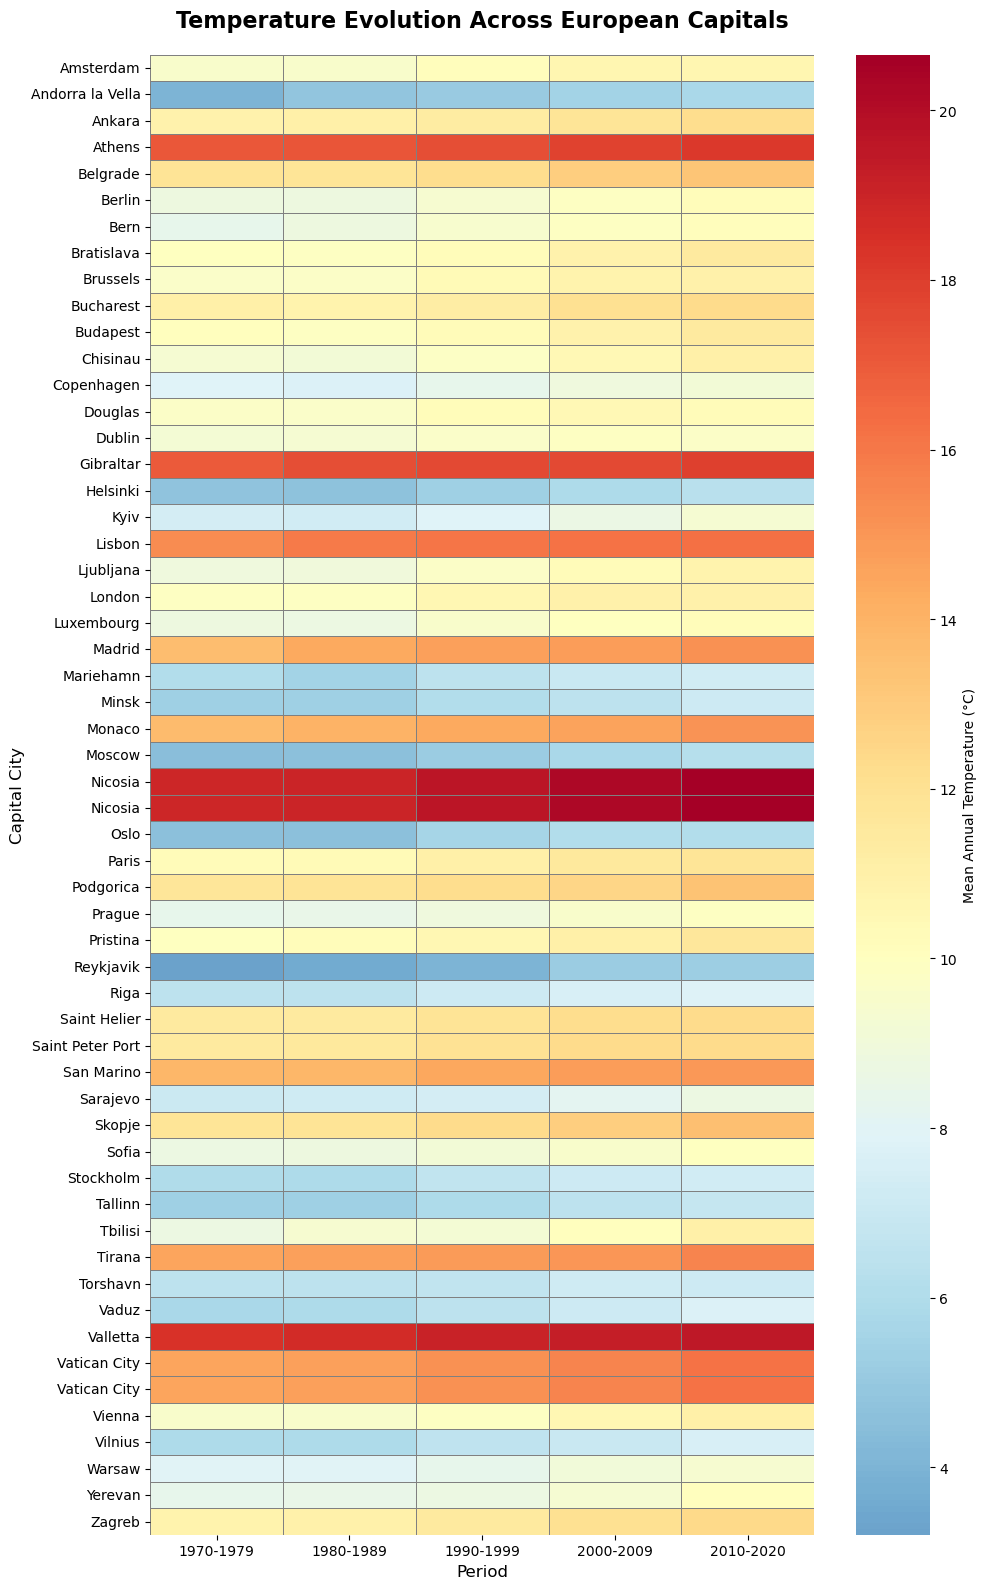

In [20]:
# Heatmap of temperature evolution across all European capitals over the decades

# Prepare data: one row per capital, one column per period
capital_temps = []
capital_names_list = []

# Get capital names from eu_capitals
for _, row in df_1970.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    
    # Find capital name
    capital = eu_capitals[(eu_capitals['latitude'].round(4) == round(lat, 4)) & 
                          (eu_capitals['longitude'].round(4) == round(lon, 4))]
    
    if not capital.empty:
        name = capital.iloc[0]['name']
        capital_names_list.append(name)
        
        # Get mean annual temp for each period
        temps_by_period = []
        for period_name in period_names:
            df = loaded_datasets[period_name]
            row_data = df[(df['latitude'] == lat) & (df['longitude'] == lon)]
            if not row_data.empty:
                mean_temp = np.mean([row_data.iloc[0][f't2m_{m}'] for m in 
                                     month_names]) - 273.15
                temps_by_period.append(mean_temp)
        
        capital_temps.append(temps_by_period)

# Create DataFrame for heatmap
heatmap_df = pd.DataFrame(capital_temps, 
                          columns=period_names, 
                          index=capital_names_list)

# Sort by latitude (north to south)
heatmap_df = heatmap_df.sort_index()

plt.figure(figsize=(10, 16))
sns.heatmap(heatmap_df, cmap='RdYlBu_r', center=10, 
            cbar_kws={'label': 'Mean Annual Temperature (°C)'},
            linewidths=0.5, linecolor='gray', annot=False)
plt.title('Temperature Evolution Across European Capitals', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Period', fontsize=12)
plt.ylabel('Capital City', fontsize=12)
plt.tight_layout()
plt.show()

Max SF: 0.0009999275
Min SF: 0.0
Max T2M: 292.73538
Min T2M: 274.51328
Max TP: 0.0044018137
Min TP: 0.002319336
Max SI10: 2.1732366
Min SI10: 1.5161611


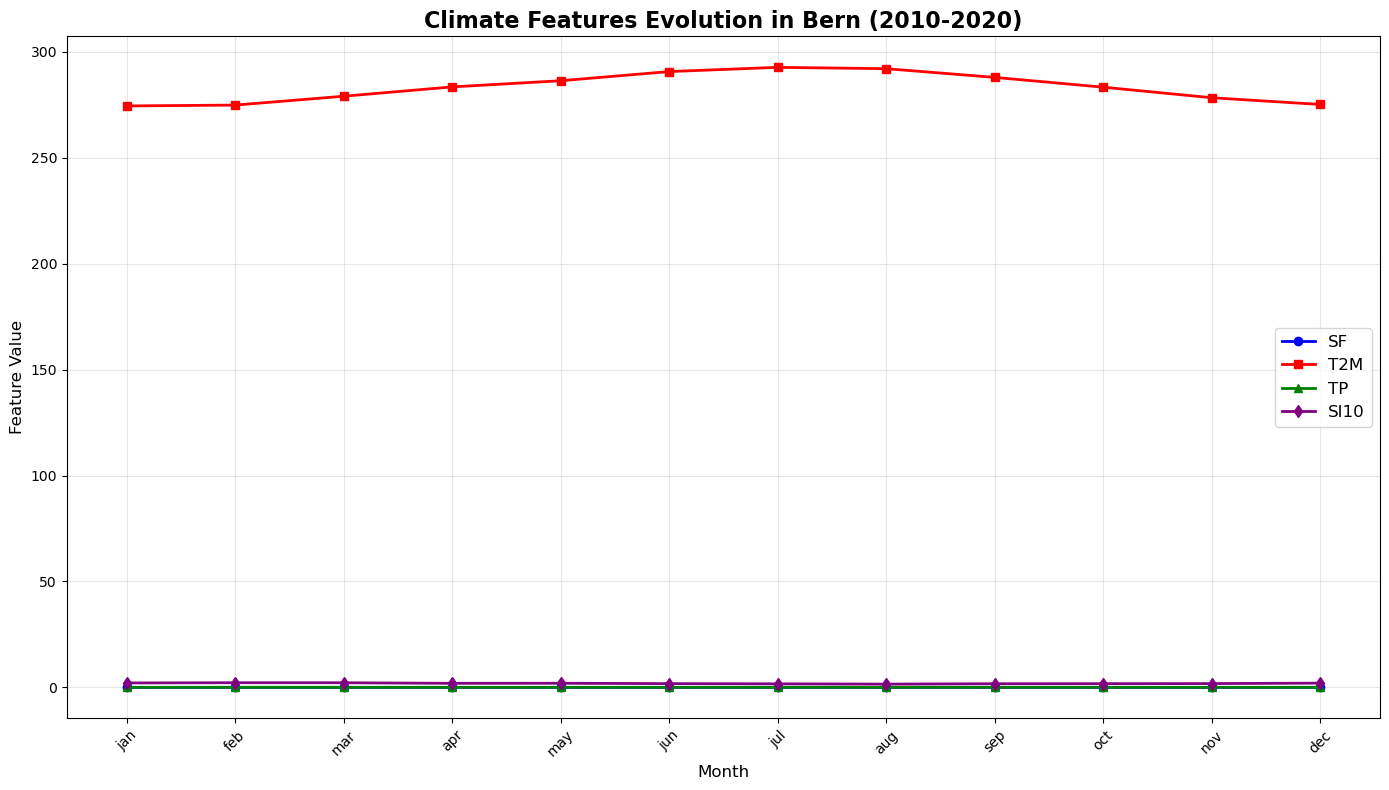

In [21]:
# Show all 4 features evolution per month for Bern in 2010-2020 on a single plot

features = ["sf", "t2m", "tp", "si10"]
period_name = '2010-2020'
df = loaded_datasets[period_name]

plt.figure(figsize=(14, 8))

bern_row = df[(df['latitude'] == bern_lat) & (df['longitude'] == bern_lon)]

if not bern_row.empty:
    colors = ['blue', 'red', 'green', 'purple']
    markers = ['o', 's', '^', 'd']
    
    for i, feat in enumerate(features):
        values = [bern_row[f'{feat}_{m}'].values[0] for m in month_names]
        plt.plot(month_names, values, marker=markers[i], linestyle='-', 
                linewidth=2, color=colors[i], label=feat.upper(), markersize=6)
        print(f"Max {feat.upper()}: {max(values)}")
        print(f"Min {feat.upper()}: {min(values)}")

plt.title('Climate Features Evolution in Bern (2010-2020)', 
         fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Feature Value', fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

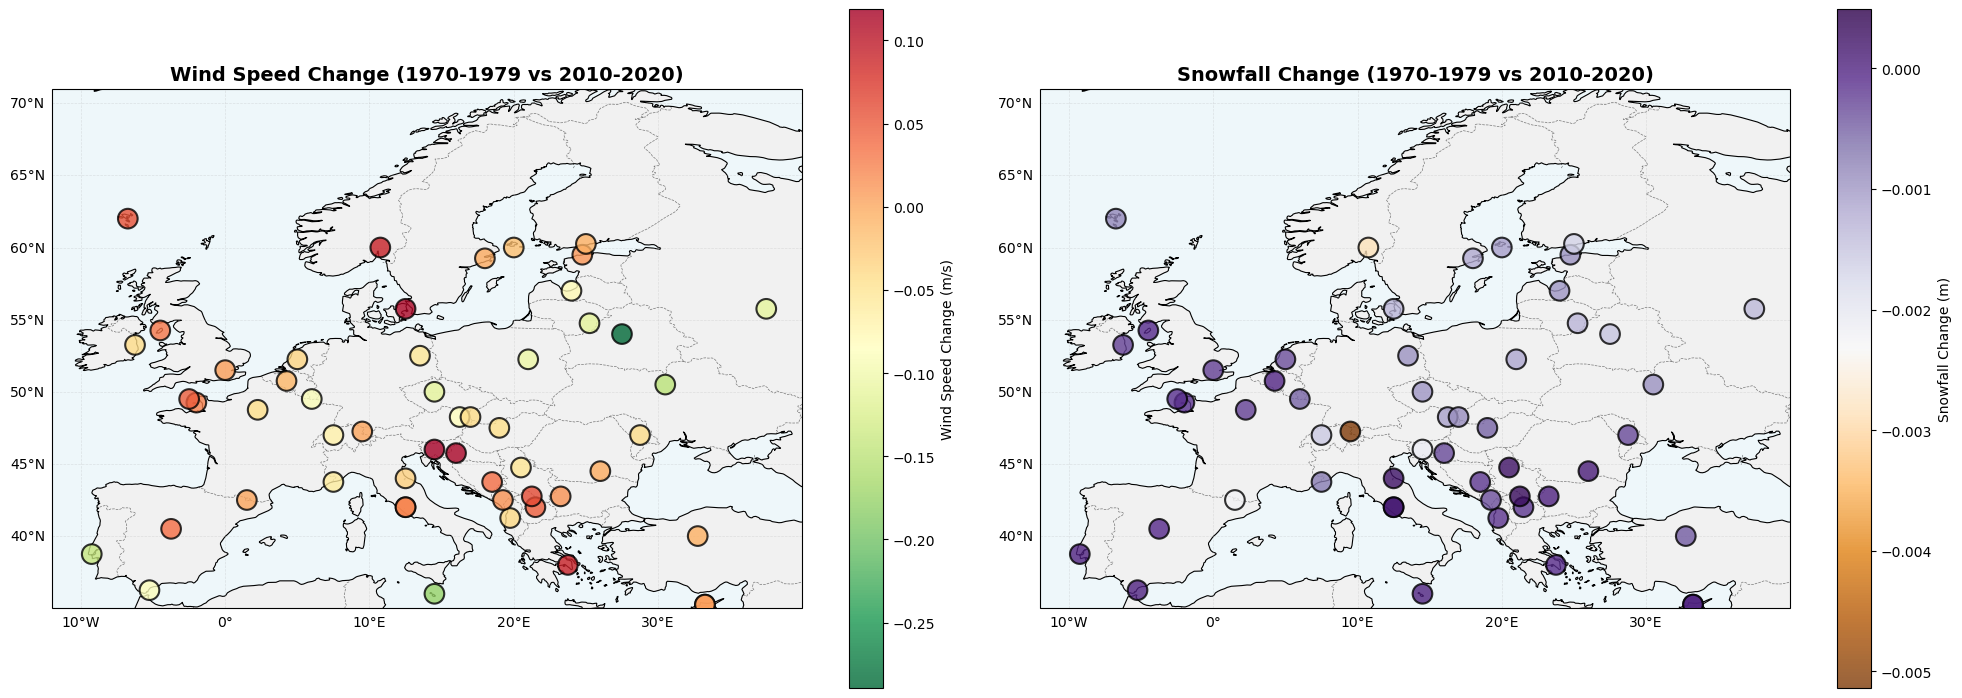

Average wind speed change: -0.018 m/s
Average snowfall change: -0.000711 m


In [22]:
# Map showing wind speed and snowfall changes across European capitals

fig, axes = plt.subplots(1, 2, figsize=(20, 10), 
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Data collection
wind_change = []
snow_change = []
lats_plot = []
lons_plot = []

for _, row_70 in df_1970.iterrows():
    lat = row_70['latitude']
    lon = row_70['longitude']
    row_10 = df_2010[(df_2010['latitude'] == lat) & (df_2010['longitude'] == lon)]
    
    if not row_10.empty:
        # Wind change (annual mean)
        wind_70 = np.mean([row_70[f'si10_{m}'] for m in month_names])
        wind_10 = np.mean([row_10.iloc[0][f'si10_{m}'] for m in month_names])
        
        # Snowfall change (annual sum)
        snow_70 = np.sum([row_70[f'sf_{m}'] for m in month_names])
        snow_10 = np.sum([row_10.iloc[0][f'sf_{m}'] for m in month_names])
        
        wind_change.append(wind_10 - wind_70)
        snow_change.append(snow_10 - snow_70)
        lats_plot.append(lat)
        lons_plot.append(lon)

# Plot 1: Wind Speed Change
ax1 = axes[0]
ax1.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax1.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='--', alpha=0.5)
ax1.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

scatter1 = ax1.scatter(lons_plot, lats_plot, c=wind_change, cmap='RdYlGn_r', 
                       s=200, edgecolors='black', linewidths=1.5,
                       transform=ccrs.PlateCarree(), zorder=5, alpha=0.8)

cbar1 = plt.colorbar(scatter1, ax=ax1, label='Wind Speed Change (m/s)', 
                     shrink=0.7, pad=0.05)
ax1.set_extent([-12, 40, 35, 71], crs=ccrs.PlateCarree())
ax1.set_title('Wind Speed Change (1970-1979 vs 2010-2020)', 
              fontsize=14, fontweight='bold')

gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# Plot 2: Snowfall Change
ax2 = axes[1]
ax2.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax2.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='--', alpha=0.5)
ax2.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

scatter2 = ax2.scatter(lons_plot, lats_plot, c=snow_change, cmap='PuOr', 
                       s=200, edgecolors='black', linewidths=1.5,
                       transform=ccrs.PlateCarree(), zorder=5, alpha=0.8)

cbar2 = plt.colorbar(scatter2, ax=ax2, label='Snowfall Change (m)', 
                     shrink=0.7, pad=0.05)
ax2.set_extent([-12, 40, 35, 71], crs=ccrs.PlateCarree())
ax2.set_title('Snowfall Change (1970-1979 vs 2010-2020)', 
              fontsize=14, fontweight='bold')

gl2 = ax2.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

plt.tight_layout()
plt.show()

print(f"Average wind speed change: {np.mean(wind_change):.3f} m/s")
print(f"Average snowfall change: {np.mean(snow_change):.6f} m")

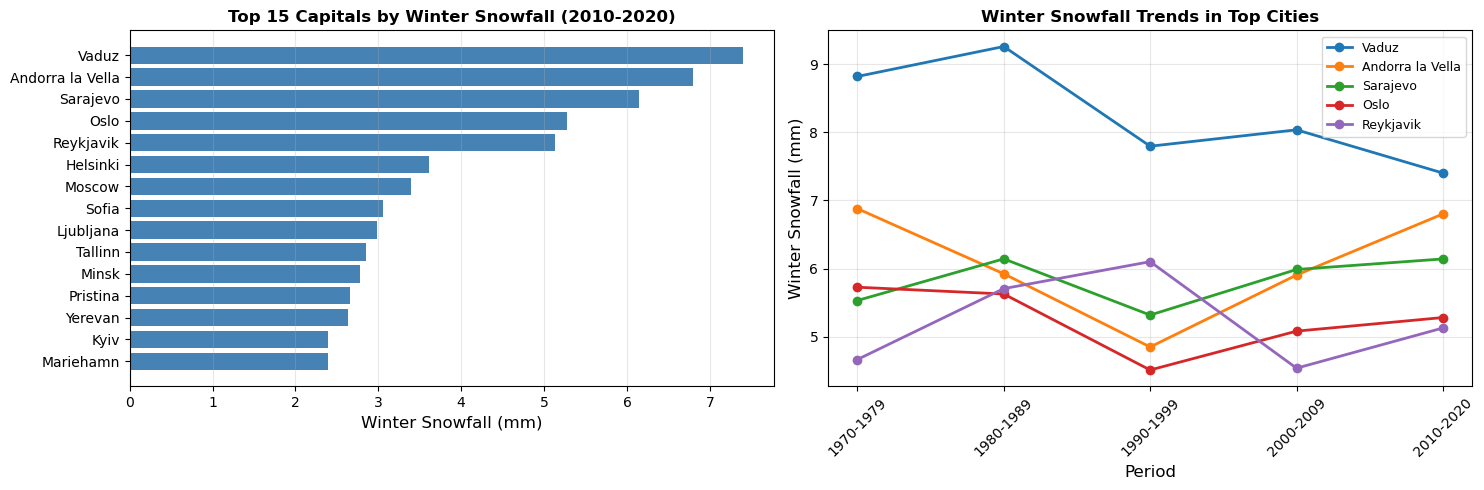

In [23]:
# Focus on winter snowfall and summer wind patterns

fig, axes = plt.subplots(1,2, figsize=(15, 5))

winter_months = ['dec', 'jan', 'feb']

# Winter Snowfall by Capital
ax1 = axes[0]
winter_snow = []
capital_names_winter = []

for _, row in df_2010.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    capital = eu_capitals[(eu_capitals['latitude'].round(4) == round(lat, 4)) & 
                          (eu_capitals['longitude'].round(4) == round(lon, 4))]
    
    if not capital.empty:
        name = capital.iloc[0]['name']
        snow_sum = sum([row[f'sf_{m}'] * 1000 for m in winter_months])
        winter_snow.append(snow_sum)
        capital_names_winter.append(name)

# Sort by snowfall
sorted_indices = np.argsort(winter_snow)[::-1][:15]  # Top 15
ax1.barh([capital_names_winter[i] for i in sorted_indices[::-1]],
         [winter_snow[i] for i in sorted_indices[::-1]],
         color='steelblue')
ax1.set_xlabel('Winter Snowfall (mm)', fontsize=12)
ax1.set_title('Top 15 Capitals by Winter Snowfall (2010-2020)', 
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Snowfall decline over decades for top cities
ax2 = axes[1]
top_cities = [capital_names_winter[i] for i in sorted_indices[:5]]

for city in top_cities:
    city_snow_evolution = []
    for period_name in period_names:
        df = loaded_datasets[period_name]
        for _, row in df.iterrows():
            lat = row['latitude']
            lon = row['longitude']
            capital = eu_capitals[(eu_capitals['latitude'].round(4) == round(lat, 4)) & 
                                  (eu_capitals['longitude'].round(4) == round(lon, 4))]
            
            if not capital.empty and capital.iloc[0]['name'] == city:
                snow_sum = sum([row[f'sf_{m}'] * 1000 for m in winter_months])
                city_snow_evolution.append(snow_sum)
                break
    
    ax2.plot(period_names, city_snow_evolution, marker='o', linewidth=2, 
             label=city, markersize=6)

ax2.set_title('Winter Snowfall Trends in Top Cities', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Period', fontsize=12)
ax2.set_ylabel('Winter Snowfall (mm)', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()